# Implementation 2D

In [1]:
%pylab inline
from pandas import read_csv, concat
from scipy.special import iv
import os
import seaborn as sns
import numba
from lmfit import  minimize, Minimizer, Parameters, Parameter, report_fit, fit_report
import warnings

################### FRET-lines #####################
def stline_tauE(tau1, tau2, tau0=1.0,n=100):
    tau = linspace(tau1,tau2,n)
  
    return tau,1.0 - tau/tau0

def stline_fi(fi1, fi2 ,n=100):
    fi = linspace(fi1,fi2,n)
  
    return fi, fi*(1.0-fi)

def dynline_tauE(tau1, E1,tau2, E2, n=100):
    tau = linspace(tau1,tau2,n)
    
    rt = tau/(tau2-tau1)
    
    e1 = 1.0/(1.0-E1)
    e2 = 1.0/(1.0-E2)
    se = e2+e1
    de = e2-e1
    
    return tau,1.0-1.0/(se+rt*de)

def line2D(x1, y1, x2, y2, n=100):
    x = linspace(x1,x2,n)
    a = (y2-y1)/(x2-x1)
    b = (y1*x2-y2*x1)/(x2-x1)
    
    return x, a*x+b

#Transformation from tauF(E) to base phi2(E)
def tF2phi(line): # to tauF(E)
    E   = line[0]
    tF  = line[1]
    phi = (1.0-E)*(1.0-tF)
    return E,phi


# Transformation of 2D lines from phi2(E) to another representations
def phi2tF(line): # to tauF(E)
    E   = line[0]
    phi = line[1]
    tF = 1.0 - phi/(1.0-E)
    return E,tF

def phi2var(line): # x axis=E; y axis ~ GG cFCS
    E   = line[0]
    phi = line[1]
    EF = phi/(1.0-E)
    return E, (E-EF)*(1.0-E)

def phi2GG(line): # x axis=E; y axis ~ GG cFCS
    E   = line[0]
    phi = line[1]
    EF = phi/(1.0-E)
    return E, (E-EF)/(1.0-E)

def phi2GR(line): # x axis=E; y axis ~ GR cFCS
    E   = line[0]
    phi = line[1]
    EF = phi/(1.0-E)
    return E, (EF-E)/E

def phi2RR(line): # x axis=E; y axis ~ RR cFCS
    E   = line[0]
    phi = line[1]
    EF = phi/(1.0-E)
    return E, (1.0-E)*(E-EF)/(E*E)


####################################################

def read_burstwise(path):                # read experimental NT distribution    
    path_bur = path+'bi4_bur'+'\\'
    path_gg  = path+'bg4'    +'\\'
    path_rg  = path+'br4'    +'\\'

    p, d, file_names = os.walk(path_bur).next()
    data_bur = concat([read_csv(path_bur+f, sep='\t', header=0)[1::2] for f in file_names])

    p, d, file_names = os.walk(path_gg).next()
    data_gg = concat([read_csv(path_gg+f, sep='\t', header=0)[1::2] for f in file_names])

    p, d, file_names = os.walk(path_rg).next()
    data_rg = concat([read_csv(path_rg+f, sep='\t', header=0)[1::2] for f in file_names])

    data = concat([data_bur,
                   data_gg,#[list(data_gg)[:-1]]
                   data_rg],#[list(data_rg)[:-1]]
                   axis=1)

    st  = data[['Number of Photons',
                'Duration (ms)']]
    st.columns = ['N','T']
    return st

class TRM(ndarray):                      # set TRM and calculate some its properties 
    # Subclassed ndarray for Transition Rate Matix (TRM)

    # TRM.EVD() - Eigenvalue Decomposition with stationary vector taken apart

    # Input ( N x N-1 array) - Left TRM with diagonal excluded

    # K     ( N x N   array) - Full Left TRM
    # k     ( N     array) - total rate to go to other states
    # Lambda
    # mu    ( N       array) - Stationary vector (first left eigenvector)
    # left  ( N-1 x N array) - Transposed Left eigenvector matrix excluding mu eigenvector
    # right ( N-1 x N array) - Right eigenvector matrix excluding 1-eigenvector

    # Formally evolution of state population vector (p) can be written as:
    #
    # p(t) = exp(K*t)*p(0) , where matrix exponentiation is assumed
    #
    # Using EVD its can be expressed as:
    #
    # p(t) = mu + dp(t)
    #
    # where:
    # dp(t) = left.T*exp(diag(k)*t)*right*p(0) - fluctuation of p
    # dp(t) is relaxing to 0-vector, so p(t) relaxing to mu
    #

    # TRM.CFA(c_left, c_right) - Amplitudes ( N-1  array) for normalized correlation function
    #                            of vectors c_left and c_right
    # CFA = (left*c_left)o(right*diag(mu)*c_right), where 'o' denote element-wise product
    # CF is: 1.0 + ( CFA * exp(Lambda*t) ), where Lambda is relaxation rates vector
    #

    def __new__(cls, input_array):
        obj = asarray(input_array).view(cls)
        obj.K     = None
        obj.Kn    = None # normilised TR from given state to all Others
        obj.mu    = None
        obj.k     = None # total rate to go to other states
        obj.Lambda= None # 
        obj.left  = None
        obj.right = None
        obj.EVD()
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.K     = getattr(obj, 'K',     None)
        self.Kn    = getattr(obj, 'Kn',    None)
        self.mu    = getattr(obj, 'mu',    None)
        self.k     = getattr(obj, 'k',     None)
        self.Lambda= getattr(obj, 'Lambda',None)
        self.left  = getattr(obj, 'left',  None)
        self.right = getattr(obj, 'right', None)
        self.EVD()

    def __array_wrap__(self, arr, context=None):
        tmp = ndarray.__array_wrap__(self, arr, context)
        tmp.EVD()
        return tmp

    def __setslice__(self, i, j, val):
        ndarray.__setslice__(self.__array__(), i, j, val)
        self.EVD()

    def __setitem__(self, i, val):
        ndarray.__setitem__(self.__array__(), i, val)
        self.EVD()

    def EVD(arr):
        A = abs(arr.__array__().copy())
        ndim = A.ndim

        if ndim > 2:
            raise ValueError("TRM must be 2-dimensional")
        elif ndim == 0:
            A = A[None,None]
        elif ndim == 1:
            A = A[None,:]

        shape = A.shape
        N = shape[0] if shape[0] > shape[1] else shape[1]+1

        K = zeros([N, N])
        K[0:shape[0], 1:(shape[1]+1)] += triu(A, 0)
        K[0:shape[0], 0:shape[1]]     += tril(A, -1)
        K = K.transpose()
        k  = sum(K, axis=0)
        
        Kn = (K/k).transpose()
        
        # Diagonal elements of transition matrix are defined by nondiagonal ones
        K -= diag(k)  # -diag(diag(K_) if nonzero diagonal        

        # EVD
        Lambda, U = linalg.eig(K)

        # sort such way that zero eigenvalue (which always exist for proper transition matrix)
        # is first
        U =          U[:, argsort(abs(Lambda))]
        Lambda  = Lambda[argsort(abs(Lambda))]

        U[:, 0] /= U[:, 0].sum()# Normalize first eigenvector (column) to get stationary distribution
        V = linalg.inv(U)            # Adjacent eigenvectors (rows)

        Lambda = Lambda[1:]     # First eigenvalue is always 0 - we dont need it
        mu     = U[:, 0]        # Take stationary distribution apart,
        U      = U[:, 1:]       # remaining saved as left eigenvector matrix
        V      = V[1:, :]       # First adjacent eigenvector is known - 1-vector,
                                # we dont need it too.
        arr.K = K
        arr.Kn = Kn
        arr.k  = k
        arr.mu = mu
        arr.Lambda = Lambda
        arr.left = U.transpose()
        arr.right = V

    def CFA(self, c_left, c_right, norm_vector=0):
        c_l = asarray(c_left)
        c_r = asarray(c_right)

        if not c_l.shape == self.mu.shape:
            raise ValueError("dimentions of left correlant and mu mismatch")
        if not c_r.shape == self.mu.shape:
            raise ValueError("dimentions of right correlant and mu mismatch")

        if norm_vector == 0:
            return self.left.dot(c_l) * self.right.dot(self.mu*c_r) / (self.mu.dot(c_l) * self.mu.dot(c_r))
        elif norm_vector == 1:
            return self.left.dot(c_l) * self.right.dot(self.mu*c_r)
        else:
            return self.left.dot(c_l) * self.right.dot(self.mu*c_r) / (norm_vector.dot(c_l) * norm_vector.dot(c_r))


class kinetics_dict(dict):               # calculate correlations
    def __init__(self, parent=None):
        self.parent = parent  # reference to parent fits dictionary (SessionData)

        # Transition matrix
        self['Ex'] = False
        self['TRM'] = TRM(ones((2, 1)))
        self['Correlants'] = array([[0.0,0.0],[1.0,1.0]])
        self['ExRates'] = zeros(1)

        # Correlation curve
        self['tc'] = logspace(-7, 3, 1000)

    def __setitem__(self, key, val):
        if key=='TRM' and  'Ex' in self.keys() and self['Ex']: # If constant excitation is present:
                                                               # 1. treate the first row of TRM as exitation rates
            dict.__setitem__(self, 'ExRates', 1.0*val[0, :])   #    1.1 save excitation rates to a separate variable
            val[0, :] = 0.0                                    #    1.2 replace the 1st row of TRM by zeros
            dict.__setitem__(self, 'TRM', val)                 # 2. save the modified TRM and calculate its SVD
                                                               # 3. calculate (as separate vars):
            val = self['TRM'].left[:,1:]                       #    3.1 reduced U
            dict.__setitem__(self, 'Uex', val)                 #    3.2 reduced V
                                                               #    3.2 reduced stationary vector in presence of Ex
            try:    val = linalg.inv(self['Uex'].T)
            except: val = empty(self['Uex'].shape) * nan
            dict.__setitem__(self, 'Vex', val)

            try:    val = -self['Uex'].T.dot(diag(1.0/self['TRM'].Lambda)).dot(self['Vex']).dot(self['ExRates'])
            except: val = empty(self['ExRates'].size) * nan
            dict.__setitem__(self, 'muex', val)

        else:
            dict.__setitem__(self, key, val)

        if key in ['TRM', 'Correlants']:
            if 'TRM' in self.keys() and 'Correlants' in self.keys():
                if self['Correlants'].size == 2*self['TRM'].mu.size:
                    dict.__setitem__(self, 'CFA', self.calculateCFA())
                    if 'tc' in self.keys():
                        dict.__setitem__(self, 'G', self.calculateG())

        if key in ['tc']:
            if 'CFA' in self.keys():
                dict.__setitem__(self, 'G', self.calculateG())

    def resize(self, n):
        if n < 2: n = 2

        nold = self['TRM'].mu.size

        m = zeros([n, n-1])
        c = zeros([n, 2])

        if n > nold:
            m[1:nold, :(nold-1)] =                                    self['TRM'][1:]
            m[0, :(nold-1)]      = self['ExRates'] if self['Ex'] else self['TRM'][0]
            c[:nold]             = self['Correlants'][:]
        else:
            m[1:] =                                            self['TRM'][1:n, :(n-1)]
            m[0]  = self['ExRates'][:(n-1)] if self['Ex'] else self['TRM'][  0, :(n-1)]
            c[:]  = self['Correlants'][:n]

        self['TRM'] =        1.0 * TRM(m)
        self['Correlants'] = 1.0 * c

    def calculateCFA(self):
        if self['Ex']:
            l = asarray(self['Correlants'][1:, 0])
            r = asarray(self['Correlants'][1:, 1])
            U = self['Uex']
            V = self['Vex']
            m = self['muex']
            return U.dot(l) * V.dot(m*r) / (m.dot(l) * m.dot(r))
        else:
            return self['TRM'].CFA(self['Correlants'][:, 0], self['Correlants'][:, 1])

    def calculateG(self):
        if isnan(self['CFA']).any():
            return 1000.0*ones(self['tc'].size)
        else:
            g = float(not self['Ex']) + self['CFA'].dot(exp(self['TRM'].Lambda[:, None]*self['tc'][None, :]))
            return g

def eqxlim(n):
    return 1.5/(1.0+0.5*n*(1.0+iv(0,0.5*n)/iv(1,0.5*n)))
################### Simulation #####################
@numba.jit(nopython=True)                # one random sampling from multinomial distribution
def rwheel(p):
    q = random.rand()#uniform random
    i = 0
    while q > 0.0:
        q -= p[i]
        i += 1
    return i - 1

@numba.jit(nopython=True)                # Gillespie: calculate fraction of times spent in states (of CTMC)
def get_Nstate(i,  # initial state
               k,  # array[i] = total rate of fransitions FROM state i; -diag of TRM
               P,  # (K - diag(K))/k_state - probabilities to go from i to j
               N,  # Number of counts in the burst
               T): # Duration of the burst
    kb = k*T

    T1 = zeros(k.size) # array = normalised (Tmax=1) times spent in states
    t = 0.0            # total time counter (tmax = 1.0)
    j = i
    while (t < 1. and kb[i]):
        j = i
        dt, i  = random.exponential(1.0/kb[j]), rwheel(P[j]) # dt - (normalised) time spent in state j 
        T1[j] += dt                                          # before transition to state i
        t     += dt
    T1[j] += 1.0 - t #last piece: if t exceedes 1.0 increase T1[j] such as sum(T1) = 1.0
    
    return (N*T1).astype(int64), i # to be exact N*T1 can be replaced to multinomial(N,T1)  

@numba.jit(nopython=True)                # simulation of burstwise E and Tauf
def simulate(NTb,                        # array[i,j] = Nburst(j=0); Tburst(j=1); i - index of burst
             peq,                        # stationary state populations
             k,                          # array[i] = total rate of fransitions FROM state i
             P,                          # (K - diag(K))/k_state
             E,                          # array[i] = efficiency in state i
             pGRS,                       
             Taug,                       # array[i] = green lifetime in state i
             change_state_between=True):
    
    Nbursts = NTb.shape[0]
    Ns      = peq.size
    NG      = zeros(Nbursts) # burstwise E
    NR      = zeros(Nbursts) # burstwise E
    Taufb   = zeros(Nbursts) # burstwise Tau

    state = rwheel(peq) # pick initial state randomly based on stationary state populations
    for burst in range(Nbursts):
        NbG, NbR, Nb = random.multinomial(int(NTb[burst,0]),pGRS)
        Tb = NTb[burst,1]
        N, state = get_Nstate(state, k, P, int(Nb), Tb) # calculate number of photons emmited in states during current burst
        
        if change_state_between: state = rwheel(peq)#  random change state between bursts 
 
        tg = 0.  # green total tac
        ng = 0   # green total counts
        for i in range(Ns):
            for j in range(N[i]):
                if E[i] < random.rand():
                    ng += 1
                    tg += random.exponential(Taug[i])
    
        NG[burst]           = NbG + ng  #
        NR[burst]           = NbR + Nb - ng
        if ng: Taufb[burst] = tg/ng      # overvise =0
        
    return NG, NR, Taufb
#####################################################

Populating the interactive namespace from numpy and matplotlib


In [26]:

kin = array([[0.32, 0  ],            # k12 k13  - from state 1   
             [0.11, 0.39  ],          # k21 k23  - from state 2
             [0.06, 0.4]])           # k31 k32  - from state 3
K = TRM(kin) #  Transition rate matrix object - EVD and correlations inside
print(-1/K.Lambda)
print(K.CFA([1,0,0],[1,0,0]),np.sum(K.CFA([1,0,0],[1,0,0])))
print(K.CFA([0,1,0],[0,1,0]),np.sum(K.CFA([0,1,0],[0,1,0])))
print(K.CFA([0,0,1],[0,0,1]),np.sum(K.CFA([0,0,1],[0,0,1])))
print(K.Lambda)
print(K.mu)
print(K.left)
print(K.right)

[2.57858498 1.12083698]
[3.53539691 0.14027877] 3.675675675675671
[0.05882498 1.29171849] 1.3505434782608707
[0.60674352 1.16569238] 1.772435897435898
[-0.3878096 -0.8921904]
[0.21387283 0.42543353 0.36069364]
[[-0.75888175  0.11853119  0.64035056]
 [-0.07228491  0.74047275 -0.66818784]]
[[-0.99636781  0.21113531  0.34176363]
 [-0.41504952  0.74214797 -0.62925094]]


# Implementation cFCS

In [3]:
def SurenWeights(data, tc=10.0):
    t    = data[0]
    g    = data[1]-1.0
    T    = 1000.0*data[2,0]# Duration in ms
    k    = data[2,1]
    
    dt = diff(t)
    dt = hstack((dt, dt[-1]))
    m = t/dt
    
    dn = dt*k
    N  =  T*k

    n = dt/dt[0]

    syn = (t<tc) + (t>=tc)*(t/tc)  # Suren-Stas :o) it was  => (t<10)+(t>=10)*10.0**(-log(t)/log(10.0)+1.0)
    
    G0 = mean(g[:5])
        
    tau = t[where(g < 0.5*G0)][0] # if t(Gmax) is needed here then this expression is not right as G0 is not always = Gmax
    
    A  = exp(-2*dt/tau)          # Suren-Stas
    F  = exp(-t/tau)
    Fs = F*F
        
    S = (G0*G0*((1.0 + Fs)*(1.0+A)/(1.0-A) + 2.0*m*Fs)*dn  + 2.0*G0*(1.0 + Fs)  + (1.0+G0*F)/dn)/N #Suren-Stas
       
    return S/syn

def cFCS_prep(FCS_aux): # for color FCS
    gGG = loadtxt(FCS_aux['FCSpath']+FCS_aux['fileGG']).T
    gGR = loadtxt(FCS_aux['FCSpath']+FCS_aux['fileGR']).T
    gRG = loadtxt(FCS_aux['FCSpath']+FCS_aux['fileRG']).T
    gRR = loadtxt(FCS_aux['FCSpath']+FCS_aux['fileRR']).T
    t = gGG[0]
    
    FCS_aux['FCSt']       = t
    FCS_aux['FCSdata']    = zeros((4,t.size))
    FCS_aux['FCSweights'] = zeros((4,t.size))
    
    FCS_aux['FCSdata'][0] = gGG[1]
    FCS_aux['FCSdata'][1] = gRR[1]
    FCS_aux['FCSdata'][2] = gGR[1]
    FCS_aux['FCSdata'][3] = gRG[1]
    
    FCS_aux['FCSweights'][0] = SurenWeights(gGG)
    FCS_aux['FCSweights'][1] = SurenWeights(gRR)
    FCS_aux['FCSweights'][2] = SurenWeights(gGR)
    FCS_aux['FCSweights'][3] = SurenWeights(gRG)

# Calculation of correlations
def FCS_kin(KO, l, r, Ps, pd, t):
    # Ps static fractions normalized to sum=1
    QL = asarray(l, dtype=float32)
    QR = asarray(r, dtype=float32)
    
    # sum(Ps) = 1
    # 0 < pd < 1
    Mu   = KO.mu
    Pt   = pd*Mu + (1.0-pd)*Ps # total fractions       
    QmmQ = Mu.dot(QL)* Mu.dot(QR)
    QppQ = Pt.dot(QL)* Pt.dot(QR)
    QpsQ = (1.0-pd)*sum(QL*QR*Ps)    

    return (pd*(KO.CFA(QL, QR, 1).dot(exp(KO.Lambda[:, None]*t[None, :])) ) + QpsQ)/QppQ #  + QmmQ  
        
def simcFCS(pars, aux_vars): # color correlations
    # **************************    INPUT   **********************************
    v = pars.valuesdict()
    # ************************  Fitted Parameters  ***************************
    KO   = TRM(array([[v['k21'], v['k31']],
                      [v['k12'], v['k32']],
                      [v['k13'], v['k23']]]
                            )) #  Transition rate matrix object - EVD and correlations inside
    Nm      = v['Nm']
    pd      = v['pdyn']
    mu_stat = array([v['ps1'],v['ps2'],v['ps3']])

    Diff    = v['Diff']
    w0      = v['w0']
    z0      = v['z0']
    
    E       = array([v['E1'] ,v['E2'] ,v['E3']])
    gamma   = v['gamma'] # 0.5    # =(PhiA/PhiD)*(gR/gG); PhiD = 0.8; PhiA = 0.32; gG  = 0.8; gR = 0.1; gG/gR = 0.8(in burbulator)
    alpha   = v['alpha'] # 0.017  # G->R crosstalk

    # *************************   Aux vars    ***************************
    t     = aux_vars['FCSt']        # - experimental times
    # *******************************************************************
    
    # Diffusion correlation
    tdiff  = w0*w0 / (4.0 * Diff)
    g_diff = 1.0  / (1.0+t/tdiff) / sqrt(1.0 + (w0/z0)**2*t/tdiff)

    # Static fractions
    Ps = mu_stat/sum(mu_stat) # static fractions sum = 1
    
    # Brightnesses (according to burbulator's brightness caculator)
    QG  = 1.0 - E  # Stas multiplies them to QD0 (typical value = 50 kilo counts per molecule)
    QR  = gamma * E + alpha * QG

    g = zeros((4,t.size))
    g[0] = FCS_kin(KO, QG, QG, Ps, pd, t) # * g_diff / Nm + 1.0 # GG
    g[1] = FCS_kin(KO, QR, QR, Ps, pd, t) # * g_diff / Nm + 1.0 # RR
    g[2] = FCS_kin(KO, QG, QR, Ps, pd, t) # * g_diff / Nm + 1.0 # GR
    g[3] = g_diff
     
    return g   

# Interface

## Simulate and plot

N burst mean    = 2268.4101708
T burst mean    = 75.9385209197 ms
Signal rate     = 29.8716664918 KHz
Transition rates matrix (KHz):
[[-3.8   0.05  1.25]
 [ 0.05 -0.1   0.05]
 [ 3.75  0.05 -1.3 ]]
Kinetic eigen rates:[0.15 5.05] KHz
Kinetic numbers    :[ 11.39077814 383.48953064]
Modal fract. range :[0.76873867 0.99220762]
Stationary fract.  :[0.16831683 0.33333333 0.49834983]


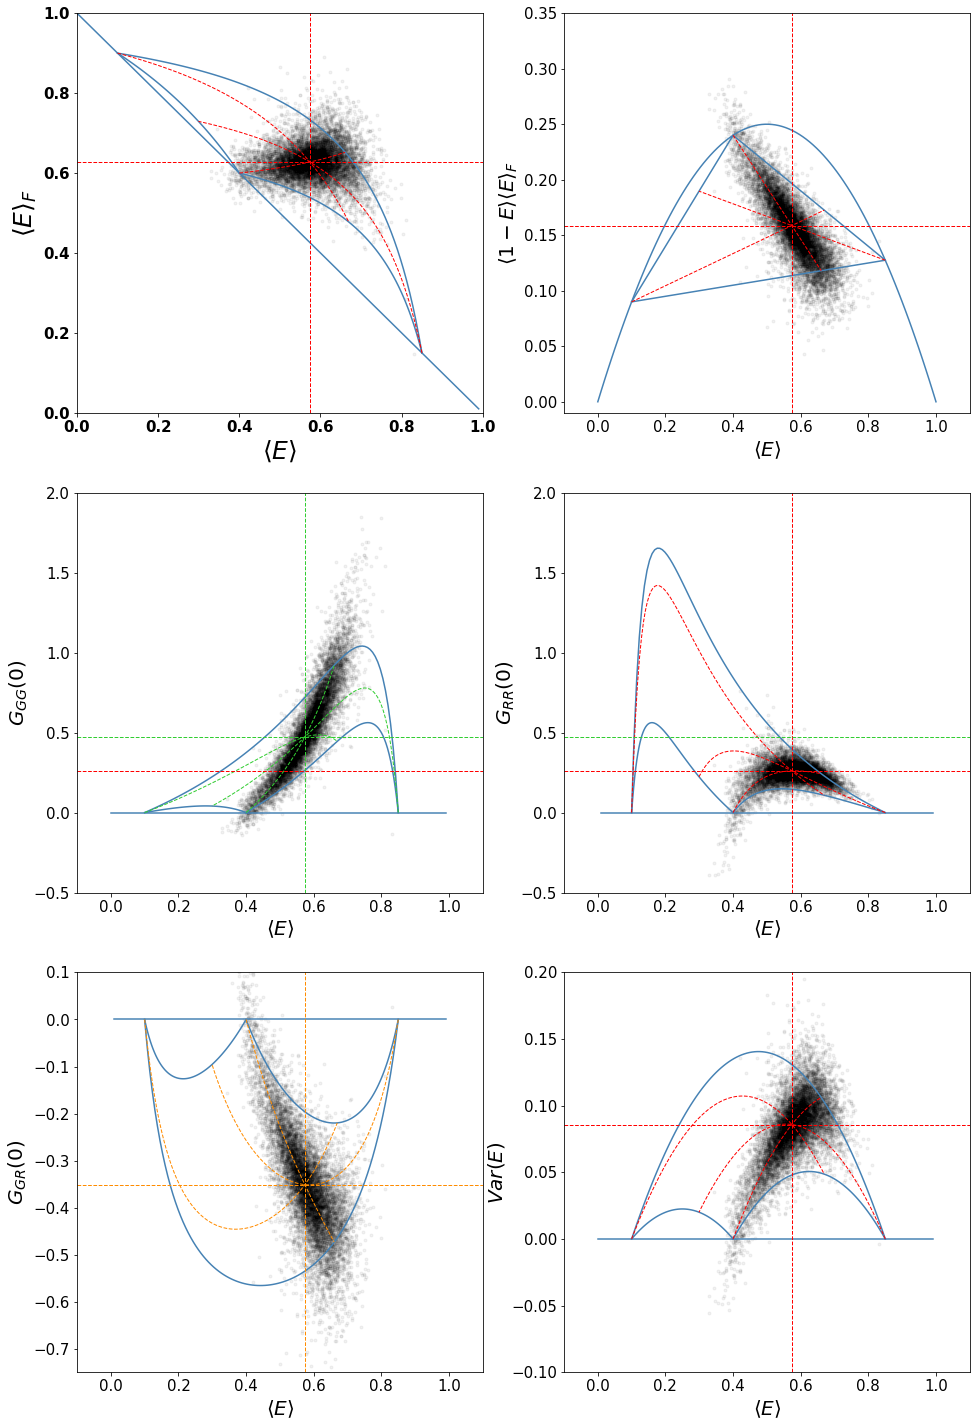

In [41]:
import warnings
import matplotlib
warnings.filterwarnings("ignore")

# Load experimental NT histogram
Nburst = 10000
st = read_burstwise('S:\\Sim2D_light\\s2doleg_dev\\Test data\\burstwise_All 0.1016#40\\')

Nfactor = 10.0
Tfactor = 10.0
st['N'] = st['N']*Nfactor
st['T'] = st['T']*Tfactor


NTb = st.values[random.randint(0,st.shape[0], size=Nburst)]
Nmean = mean(st['N'])
Tmean = mean(st['T'])
print 'N burst mean    = ' +str(Nmean)
print 'T burst mean    = ' +str(Tmean) +' ms'
print 'Signal rate     = ' +str(Nmean/Tmean) +' KHz'


################## Input values  ###################
E = array([0.1,0.4,0.85])
Bg = array([1.5,1.5]) #Green, red, in KHz
#Tau0 = 4.0
Tau  = (1.0 - E)#*Tau0

#Transition rates kin
kin = array([[0.1, 7.5  ],            # k21 k31  - from state 1   
             [0.1, 0.1  ],          # k12 k32  - from state 2
             [2.5, 0.1]              # k13 k23  - from state 3
                           ])    /2.

KO = TRM(kin) # transition rates object - EVD and all other staf is inside
print 'Transition rates matrix (KHz):'
print KO.K
print 'Kinetic eigen rates:' +str(-KO.Lambda) +' KHz'
print 'Kinetic numbers    :' +str(-KO.Lambda*Tmean)
print 'Modal fract. range :' +str(1.0-2.0*eqxlim(-KO.Lambda*Tmean))
print 'Stationary fract.  :' +str(KO.mu)
################### End of Input ######################

########### Prepare Input for FCS #########
cFCS_data = { # here only nessesary to read the values of correlation times tc
    'FCSpath': 'K:\\Papers\\FRET-Lines\\FRET-lines - All Files\\Simulations for paper_sf\\2_simulation 1\\SoftCorr_nc32\\',
    'fileGG'  : 'MCSg_pg_s--g_pg_s.cor', #
    'fileRR'  : 'MCSg_pg_s--r_pr_s.cor', #
    'fileGR'  : 'MCSr_pr_s--g_pg_s.cor', #
    'fileRG'  : 'MCSr_pr_s--r_pr_s.cor', #
    'FCSchi'  : 33.736028,
    'FCSfit'  : 1 }; cFCS_prep(cFCS_data); 

cFCS_pars = Parameters(); cFCS_pars.add_many(
    ('E1'   , E[0]       ,    True, 1.0e-7, 1.0  , None   , None),
    ('E2'   , E[1]       ,    True, 1.0e-7, 1.0  , None   , None),
    ('E3'   , E[2]       ,    True, 1.0e-7, 1.0  , None   , None),
    ('k31'  , kin[0,1]   ,    True, 0     , 200.  , None  , None), 
    ('k13'  , kin[2,0]   ,    True, 0     , 200.  , None  , None),
    ('k32'  , kin[1,1]   ,    True, 0     , 200.  , None  , None), 
    ('k23'  , kin[2,1]   ,    True, 0     , 200.  , None  , None), 
    ('k12'  , kin[1,0]   ,    True, 0     , 200.  , None  , None),
    ('k21'  , kin[0,0]   ,    True, 0     , 200.  , None  , None),

    ('pdyn' , 0.9999     ,    True, 0.0   , 1.0   , None  , None),
    ('ps1'  , 0.3        ,    True, 0.0   , 1.0   , None  , None),
    ('ps2'  , 0.3        ,    True, 0.0   , 1.0   , None  , None),
    ('ps3'  , 0.3        ,    True, 0.0   , 1.0   , None  , None),

    ('Nm'   , 0.015      ,    True, 0.001 , 1.0   , None  , None),
    ('Diff' , 0.002      ,    True, 1.0e-4, 1.0e-1, None  , None),
    ('w0'   , 0.2        ,   False, 0.0   , 10.   , None  , None),
    ('z0'   , 0.6        ,   False, 0.0   , 10.   , None  , None),

    ('gamma', 1.0        ,   False, 0.0   , 1.0   , None  , None),
    ('alpha', 0.0        ,   False, 0.0   , 1.0   , None  , None),
    
    ('f'    , 1.0        ,   False, 0.01  , 20.0  , None  , None)) #
########### End of FCS input ###########################

########################################################
####################### Simulate  ######################
#NTb = ones((Nburst,2))
#NTb[:,0] *= Nmean
#NTb[:,1] *= Tmean
NTb = st.values[random.randint(0,st.shape[0], size=Nburst)]
pGRS = array([Bg[0], Bg[1], Nmean/Tmean-Bg[0]-Bg[1]])
pGRS /= sum(pGRS)
NbG, NbR, tauFb = simulate(NTb,
                           KO.mu, KO.k, KO.Kn,
                           E, pGRS, Tau)
Eb  = (NbR-Bg[1]*NTb[:,1])/(NbR + NbG - (Bg[0]+Bg[1])*NTb[:,1])
cFCS_theor = simcFCS(cFCS_pars, cFCS_data)
tc = cFCS_data['FCSt']
GGt = cFCS_theor[0]
RRt = cFCS_theor[1]
GRt = cFCS_theor[2]
Gdiff = cFCS_theor[3]
#################### End of Similate  ###################
#########################################################

Petfb = (Eb,tauFb)    # Traditional
Pepib = tF2phi(Petfb) # Linear
Pevb  = phi2var(Pepib)# Variance
Peggb = phi2GG(Pepib) # GG(E)
Pegrb = phi2GR(Pepib) # GR(E)
Perrb = phi2RR(Pepib) # RR(E)

#### Equilibriunm fractions moments ##############
xd     = KO.mu

xd01   = xd[[0,1]]/sum(xd[[0,1]])
xd12   = xd[[1,2]]/sum(xd[[1,2]])
xd02   = xd[[0,2]]/sum(xd[[0,2]])

MeanE  = E.dot(xd)
MeanE2 = (E*E).dot(xd)
VarE   = MeanE2 - MeanE**2
EF     = (MeanE-MeanE2)/(1.0-MeanE)
tF     = 1.0 - EF
Ph2    = (1.0-MeanE)*EF
GG     = VarE/(1.0-MeanE)**2
RR     = VarE/MeanE**2
GR     = -VarE/MeanE/(1.0-MeanE)

############## FRET lines ###############
# base (linear) form: phi(E)                                
Lepist = stline_fi(0.0, 1.0);                                 

Lepi0 = line2D(E[0], E[0]*(1.-E[0]), E[[1,2]].dot(xd12), (E[[1,2]]*(1.-E[[1,2]])).dot(xd12));
Lepi1 = line2D(E[1], E[1]*(1.-E[1]), E[[0,2]].dot(xd02), (E[[0,2]]*(1.-E[[0,2]])).dot(xd02));
Lepi2 = line2D(E[2], E[2]*(1.-E[2]), E[[0,1]].dot(xd01), (E[[0,1]]*(1.-E[[0,1]])).dot(xd01));
Lepi01 = line2D(E[0], E[0]*(1.-E[0]), E[1], E[1]*(1.-E[1]));  
Lepi02 = line2D(E[0], E[0]*(1.-E[0]), E[2], E[2]*(1.-E[2]));  
Lepi12 = line2D(E[1], E[1]*(1.-E[1]), E[2], E[2]*(1.-E[2]));

#Traditional: tauF(E)
Letfst = phi2tF(Lepist); # static
Letf0 = phi2tF(Lepi0);
Letf1 = phi2tF(Lepi1);
Letf2 = phi2tF(Lepi2);
Letf01 = phi2tF(Lepi01);
Letf02 = phi2tF(Lepi02);
Letf12 = phi2tF(Lepi12);

#Variance: VarE(E)
Levst = phi2var(Lepist); # static
Lev0 = phi2var(Lepi0);
Lev1 = phi2var(Lepi1);
Lev2 = phi2var(Lepi2);
Lev01 = phi2var(Lepi01);
Lev02 = phi2var(Lepi02);
Lev12 = phi2var(Lepi12);

#FCS GG: GG(EF)
Leggst = phi2GG(Lepist); # static
Legg0 = phi2GG(Lepi0);
Legg1 = phi2GG(Lepi1);
Legg2 = phi2GG(Lepi2);
Legg01 = phi2GG(Lepi01);
Legg02 = phi2GG(Lepi02);
Legg12 = phi2GG(Lepi12);

#FCS GR: GR(E)
Legrst = phi2GR(Lepist); # static
Legr0 = phi2GR(Lepi0);
Legr1 = phi2GR(Lepi1);
Legr2 = phi2GR(Lepi2);
Legr01 = phi2GR(Lepi01);
Legr02 = phi2GR(Lepi02);
Legr12 = phi2GR(Lepi12);

#FCS RR: RR(EF)
Lerrst = phi2RR(Lepist); # static
Lerr0  = phi2RR(Lepi0);
Lerr1  = phi2RR(Lepi1);
Lerr2  = phi2RR(Lepi2);
Lerr01 = phi2RR(Lepi01);
Lerr02 = phi2RR(Lepi02);
Lerr12 = phi2RR(Lepi12);
########## End of FRET-lenes ##################

ymax = 0.35
#### Plot scatter
figure(figsize=(16,25))

# tF(<E>)
subplot(3, 2, 1)
xlim(0.0,1.0);
ylim(0.0,1.0);
xlabel(r'$\left< E \right>$', fontsize=25);
ylabel(r'$\left< E \right>_F$', fontsize=25);
yticks(fontsize=15, weight='bold')
xticks(fontsize=15, weight='bold')

plot(Petfb[0], Petfb[1], 'k.', alpha=0.05);        # bursts

plot(Letfst[0], Letfst[1], 'steelblue',  # lines
     Letf01[0], Letf01[1], 'steelblue',
     Letf02[0], Letf02[1], 'steelblue',
     Letf12[0], Letf12[1], 'steelblue');
plot(Letf0[0], Letf0[1],
     Letf1[0], Letf1[1],
     Letf2[0], Letf2[1],
     xlim(), [tF,tF],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0);

# Ph2(<E>)
subplot(3, 2, 2)
xlim(-0.1,1.1);
ylim(-0.01,ymax);
xlabel(r'$\left< E \right>$', fontsize=20);
ylabel(r'$\left<1-E\right>\left<E\right>_F$', fontsize=20);
tick_params(labelsize=15);

plot(Pepib[0], Pepib[1], 'k.', alpha=0.05);        # bursts

plot(Lepist[0], Lepist[1], 'steelblue',  # lines
     Lepi01[0], Lepi01[1], 'steelblue',
     Lepi02[0], Lepi02[1], 'steelblue',
     Lepi12[0], Lepi12[1], 'steelblue');

plot(Lepi0[0], Lepi0[1],
     Lepi1[0], Lepi1[1],
     Lepi2[0], Lepi2[1],
     xlim(), [Ph2,Ph2],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0);

subplot(3, 2, 3)
xlim(-0.1,1.1);
ylim(-0.5,2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{GG}(0)$', fontsize=20);
tick_params(labelsize=15);

plot(Peggb[0], Peggb[1], 'k.', alpha=0.05);

plot(Leggst[0], Leggst[1], 'steelblue',  # lines
     Legg01[0], Legg01[1], 'steelblue',
     Legg02[0], Legg02[1], 'steelblue',
     Legg12[0], Legg12[1], 'steelblue');

plot(Legg0[0], Legg0[1],
     Legg1[0], Legg1[1],
     Legg2[0], Legg2[1],
     xlim(), [GG,GG],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'limegreen',
     linewidth=1.0)
plot(xlim(), [RR,RR],
     linestyle='--',
     color = 'r',
     linewidth=1.0);

subplot(3, 2, 4)
xlim(-0.1,1.1);
ylim(-0.5,2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{RR}(0)$', fontsize=20);
tick_params(labelsize=15);

plot(Perrb[0], Perrb[1], 'k.', alpha=0.05);

plot(Lerrst[0], Lerrst[1], 'steelblue',  # lines
     Lerr01[0], Lerr01[1], 'steelblue',
     Lerr02[0], Lerr02[1], 'steelblue',
     Lerr12[0], Lerr12[1], 'steelblue');
plot(Lerr0[0], Lerr0[1],
     Lerr1[0], Lerr1[1],
     Lerr2[0], Lerr2[1],
     xlim(), [RR,RR],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0)
plot(xlim(), [GG,GG],
     linestyle='--',
     color = 'limegreen',
     linewidth=1.0);

subplot(3, 2, 5)
xlim(-0.1,1.1);
ylim(-0.75,0.1);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{GR}(0)$', fontsize=20);
tick_params(labelsize=15);

plot(Pegrb[0], Pegrb[1], 'k.', alpha=0.05);

plot(Legrst[0], Legrst[1], 'steelblue',  # lines
     Legr01[0], Legr01[1], 'steelblue',
     Legr02[0], Legr02[1], 'steelblue',
     Legr12[0], Legr12[1], 'steelblue');
plot(Legr0[0], Legr0[1],
     Legr1[0], Legr1[1],
     Legr2[0], Legr2[1],
     xlim(), [GR,GR],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'darkorange',
     linewidth=1.0);

subplot(3, 2, 6)
xlim(-0.1,1.1);
ylim(-0.1,0.2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$Var(E)$', fontsize=20);
tick_params(labelsize=15);

plot(Pevb[0], Pevb[1], 'k.', alpha=0.05);

plot(Levst[0], Levst[1], 'steelblue',  # lines
     Lev01[0], Lev01[1], 'steelblue',
     Lev02[0], Lev02[1], 'steelblue',
     Lev12[0], Lev12[1], 'steelblue');
plot(Lev0[0], Lev0[1],
     Lev1[0], Lev1[1],
     Lev2[0], Lev2[1],
     xlim(), [VarE,VarE],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'red',
     linewidth=1.0);


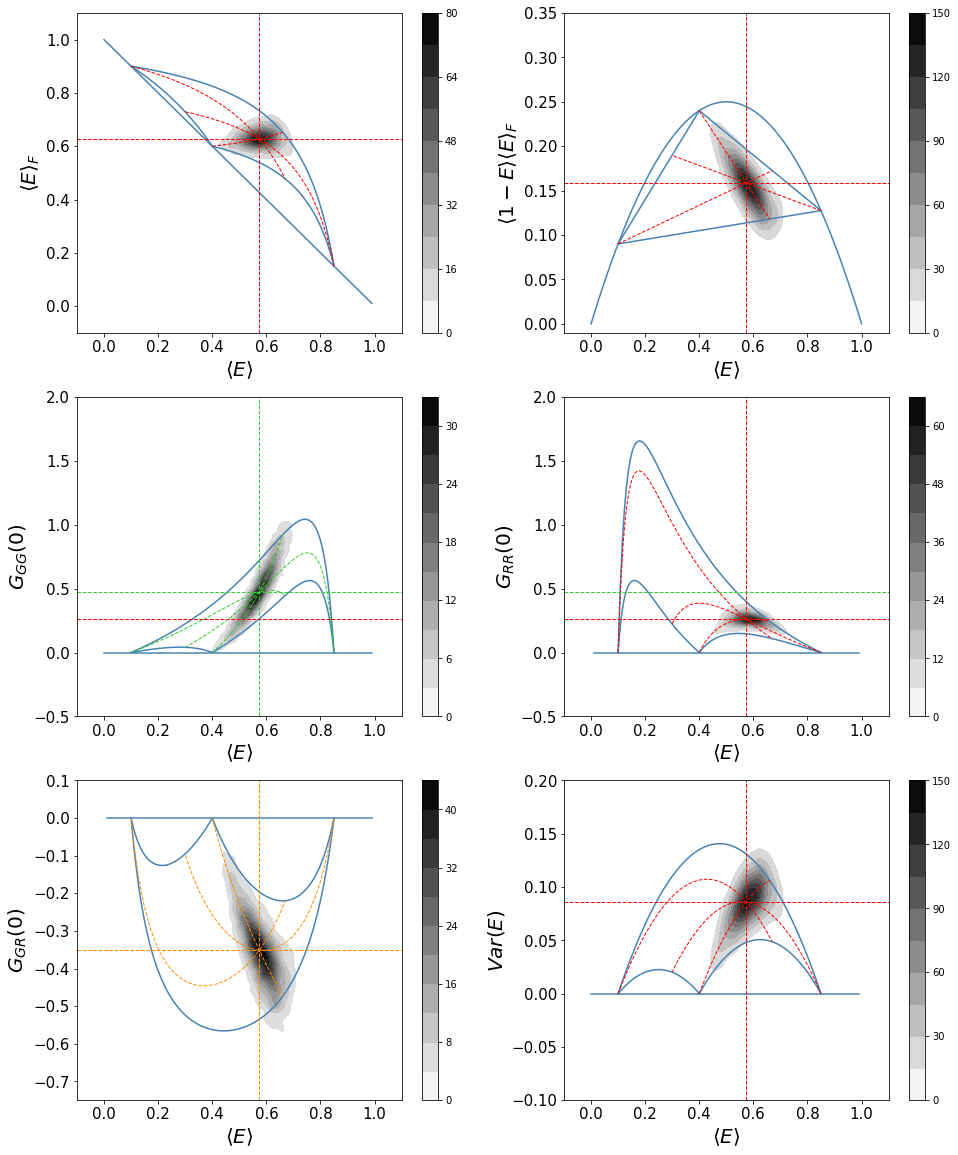

In [32]:
#### Plot KDE
from scipy.stats import gaussian_kde

#### Plot scatter
figure(figsize=(16,20))


# tF(<E>)
subplot(3, 2, 1)
xlim(-0.1,1.1);
ylim(-0.1,1.1);
xlabel(r'$\left< E \right>$', fontsize=20);
ylabel(r'$\left< E \right>_F$', fontsize=20);
tick_params(labelsize=15);

# plot(Petfb[0], Petfb[1], '.', alpha=0.05);        # bursts
sns.kdeplot(Petfb[0], Petfb[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
            );

plot(Letfst[0], Letfst[1], 'steelblue',  # lines
     Letf01[0], Letf01[1], 'steelblue',
     Letf02[0], Letf02[1], 'steelblue',
     Letf12[0], Letf12[1], 'steelblue');
plot(Letf0[0], Letf0[1],
     Letf1[0], Letf1[1],
     Letf2[0], Letf2[1],
     xlim(), [tF,tF],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0);


# Ph2(<E>)
subplot(3, 2, 2)
xlim(-0.1,1.1);
ylim(-0.01,ymax);
xlabel(r'$\left< E \right>$', fontsize=20);
ylabel(r'$\left<1-E\right>\left<E\right>_F$', fontsize=20);
tick_params(labelsize=15);

#plot(Pepib[0], Pepib[1], '.', alpha=0.05);
sns.kdeplot(Pepib[0], Pepib[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
            );
plot(Lepist[0], Lepist[1], 'steelblue',  # lines
     Lepi01[0], Lepi01[1], 'steelblue',
     Lepi02[0], Lepi02[1], 'steelblue',
     Lepi12[0], Lepi12[1], 'steelblue');

plot(Lepi0[0], Lepi0[1],
     Lepi1[0], Lepi1[1],
     Lepi2[0], Lepi2[1],
     xlim(), [Ph2,Ph2],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0);


subplot(3, 2, 3)
xlim(-0.1,1.1);
ylim(-0.5,2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{GG}(0)$', fontsize=20);
tick_params(labelsize=15);

#plot(Peggb[0], Peggb[1], '.', alpha=0.05);
sns.kdeplot(Peggb[0], Peggb[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
            );
plot(Leggst[0], Leggst[1], 'steelblue',  # lines
     Legg01[0], Legg01[1], 'steelblue',
     Legg02[0], Legg02[1], 'steelblue',
     Legg12[0], Legg12[1], 'steelblue');

plot(Legg0[0], Legg0[1],
     Legg1[0], Legg1[1],
     Legg2[0], Legg2[1],
     xlim(), [GG,GG],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'limegreen',
     linewidth=1.0)
plot(xlim(), [RR,RR],
     linestyle='--',
     color = 'r',
     linewidth=1.0);



subplot(3, 2, 4)
xlim(-0.1,1.1);
ylim(-0.5,2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{RR}(0)$', fontsize=20);
tick_params(labelsize=15);

#plot(Perrb[0], Perrb[1], '.', alpha=0.05);
sns.kdeplot(Perrb[0], Perrb[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
           );

plot(Lerrst[0], Lerrst[1], 'steelblue',  # lines
     Lerr01[0], Lerr01[1], 'steelblue',
     Lerr02[0], Lerr02[1], 'steelblue',
     Lerr12[0], Lerr12[1], 'steelblue');
plot(Lerr0[0], Lerr0[1],
     Lerr1[0], Lerr1[1],
     Lerr2[0], Lerr2[1],
     xlim(), [RR,RR],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'r',
     linewidth=1.0)
plot(xlim(), [GG,GG],
     linestyle='--',
     color = 'limegreen',
     linewidth=1.0);



subplot(3, 2, 5)
xlim(-0.1,1.1);
ylim(-0.75,0.1);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$G_{GR}(0)$', fontsize=20);
tick_params(labelsize=15);


#plot(Pegrb[0], Pegrb[1], '.', alpha=0.05);
sns.kdeplot(Pegrb[0], Pegrb[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
           );
plot(Legrst[0], Legrst[1], 'steelblue',  # lines
     Legr01[0], Legr01[1], 'steelblue',
     Legr02[0], Legr02[1], 'steelblue',
     Legr12[0], Legr12[1], 'steelblue');
plot(Legr0[0], Legr0[1],
     Legr1[0], Legr1[1],
     Legr2[0], Legr2[1],
     xlim(), [GR,GR],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'darkorange',
     linewidth=1.0);



subplot(3, 2, 6)
xlim(-0.1,1.1);
ylim(-0.1,0.2);
xlabel(r'$\left<E\right>$', fontsize=20);
ylabel(r'$Var(E)$', fontsize=20);
tick_params(labelsize=15);

#plot(Pevb[0], Pevb[1], '.', alpha=0.05);
sns.kdeplot(Pevb[0], Pevb[1], 
            cmap = "binary", shade=True, n_levels=10,
            bw   = (0.01,0.01),
            clip =(xlim(),ylim()),
            cbar = True,
            shade_lowest = False
           );
plot(Levst[0], Levst[1], 'steelblue',  # lines
     Lev01[0], Lev01[1], 'steelblue',
     Lev02[0], Lev02[1], 'steelblue',
     Lev12[0], Lev12[1], 'steelblue');
plot(Lev0[0], Lev0[1],
     Lev1[0], Lev1[1],
     Lev2[0], Lev2[1],
     xlim(), [VarE,VarE],
     [MeanE, MeanE], ylim(),
     linestyle='--',
     color = 'red',
     linewidth=1.0);

0.4726535468440811
0.260844901401866
-0.35112571512748336


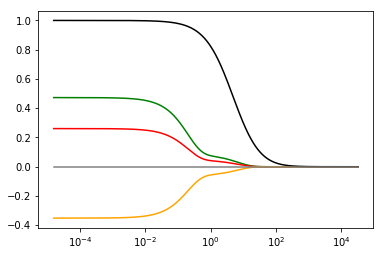

In [42]:
semilogx(tc,GGt,'g',
         tc,RRt,'r',
         tc,GRt,'orange',
         tc,Gdiff,'k',
         tc,zeros(tc.size),'gray');
print GG
print RR
print GR